In [1]:
import sys
import pathlib
import pandas as pd
import numpy as np
import boto3

ROOT = pathlib.Path().absolute().parent.as_posix()
if ROOT not in sys.path:
    sys.path.append(ROOT)
    
from helpers import *

In [2]:
client = boto3.client('s3')
bucket='asdi-hackathon'
file_key = 'aq-sentinel/aerosol-index/ai_sentinel_01-16june.csv'
obj = client.get_object(Bucket=bucket, Key=file_key)
df = pd.read_csv(obj['Body'])

In [3]:
df.head()

,aerosol_index_340_380,qa_value,time,latitude,longitude
0,-0.793254,1.0,2022-06-01,51.259598,0.292720
1,-0.168753,1.0,2022-06-01,51.303303,0.252287
2,-0.755256,1.0,2022-06-01,51.271698,0.059670
3,-0.427728,1.0,2022-06-01,51.346848,0.211568
4,-0.624933,1.0,2022-06-01,51.315163,0.018826


<AxesSubplot:>

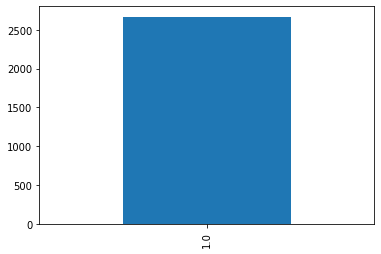

In [4]:
%matplotlib inline
df['qa_value'].value_counts().plot(kind = 'bar')

In [5]:
#problem with temporal variance in data smoothed by setting qa value, a lot of low quality recordings causing a lot of the variational disturbances
df = df[df['qa_value'] >= 1]   #1 for greatest quality measurements (as recommended by Sentinel dataset documentation)

In [6]:
import plotly.express as px

fig = px.scatter_mapbox(df, 
                        lat='latitude', 
                        lon='longitude',
                        color = 'aerosol_index_340_380',
                        center=dict(lat=51.5072, lon=0.1276), zoom=8,
                        mapbox_style="carto-darkmatter",
                        opacity = 0.5,
                        color_continuous_scale=px.colors.sequential.RdBu)

fig.show()

In [7]:
#haversine requires latitude and longitude in radians
import math
df['latitude'] = df['latitude'].apply(math.radians)
df['longitude'] = df['longitude'].apply(math.radians)

In [8]:
!pip3 install tqdm --quiet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

df_train, df_test = train_test_split(df, random_state = 0, test_size = 0.01)

X_train = df_train[['latitude', 'longitude']]
y_train = df_train['aerosol_index_340_380'].ravel()
X_test = df_test[['latitude', 'longitude']]
y_test = df_test['aerosol_index_340_380'].ravel()

#X = df[['latitude', 'longitude']]
#y = df['aerosol_index_340_380'].ravel()

k_range = range(1, 200)
k_scores = []

#uses 1 data point taken out as validation set with rest used for "training"
cv = LeaveOneOut()

from tqdm import tqdm
for k in tqdm(k_range):
    model = KNeighborsRegressor(n_neighbors=k, weights = 'distance', algorithm = 'brute', metric = 'haversine', n_jobs = -1)
    loss = abs(cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', n_jobs = -1))
    k_scores.append(loss.mean())

model.fit(X_train, y_train)

100%|██████████| 199/199 [07:28<00:00,  2.25s/it]


KNeighborsRegressor(algorithm='brute', metric='haversine', n_jobs=-1,
                    n_neighbors=199, weights='distance')

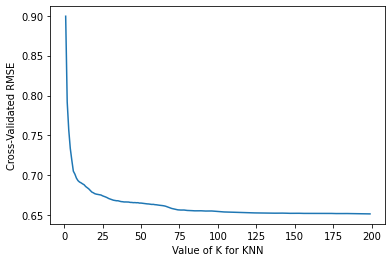

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated RMSE')
plt.show()

In [10]:
y_pred = model.predict(X_test)
results = pd.DataFrame(dtype = 'object')
results['y_test'] = y_test
results['y_pred'] = y_pred
results['difference'] = y_test - y_pred
results['abs_diff'] = abs(y_test - y_pred)
results.head()

,y_test,y_pred,difference,abs_diff
0,-0.281351,-1.019770,0.738419,0.738419
1,-0.851173,-0.895364,0.044191,0.044191
2,-0.361820,-0.799715,0.437895,0.437895
3,-0.816159,-0.720490,-0.095670,0.095670
4,-0.506467,-0.988627,0.482159,0.482159


In [11]:
results.describe()

,y_test,y_pred,difference,abs_diff
count,27.000000,27.000000,27.000000,27.000000
mean,-0.729846,-0.898181,0.168335,0.645594
std,0.826842,0.103954,0.800961,0.488000
min,-1.925685,-1.090461,-1.042073,0.018167
25%,-1.383691,-0.981196,-0.416923,0.294439
50%,-0.860583,-0.892189,-0.095670,0.477534
75%,-0.181525,-0.822147,0.715367,0.992466
max,1.046792,-0.720490,1.827183,1.827183


<AxesSubplot:>

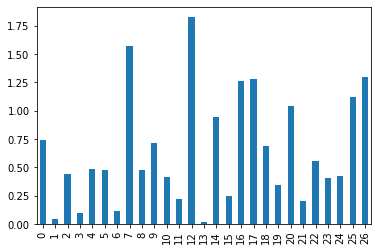

In [12]:
results['abs_diff'].plot.bar()

In [13]:
df['aerosol_index_340_380'].describe()

count    2668.000000
mean       -0.877498
std         0.794983
min        -2.951205
25%        -1.484077
50%        -0.922101
75%        -0.401172
max         2.055388
Name: aerosol_index_340_380, dtype: float64

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state = 0, test_size = 0.01)

X_train = df_train[['latitude', 'longitude']]
y_train = df_train['aerosol_index_340_380'].ravel()
X_test = df_test[['latitude', 'longitude']]
y_test = df_test['aerosol_index_340_380'].ravel()

#X = df[['latitude', 'longitude']]
#y = df['aerosol_index_340_380'].ravel()

cv = LeaveOneOut()

parameters = {'n_neighbors': np.arange(start=1, stop=200, step=2)}
grid_search = GridSearchCV(KNeighborsRegressor(weights = 'distance', algorithm = 'brute', metric = 'haversine'), 
                           param_grid = parameters, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs = -1,
                           cv = cv,
                           error_score = 'raise')
grid_search.fit(X_train, y_train)

print('best parameter(s): ', grid_search.best_params_)
print('best score(s): ', grid_search.best_score_)

best parameter(s):  {'n_neighbors': 197}
best score(s):  -0.6516532114589222


In [15]:
#use all of data in train
X_train = df[['latitude', 'longitude']]
y_train = df['aerosol_index_340_380'].ravel()

#use best k value
k = grid_search.best_params_['n_neighbors']
model = KNeighborsRegressor(n_neighbors=k, weights = 'distance', algorithm = 'brute', metric = 'haversine', n_jobs = -1)
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='brute', metric='haversine', n_jobs=-1,
                    n_neighbors=197, weights='distance')

In [16]:
# pickle final model locally
# import pickle
# filename = ROOT + '/Pickles/ai_model.pkl'
# pickle.dump(model, open(filename, 'wb'))

In [17]:
#upload pickle to s3 bucket's pickles folder
upload_pickle_to_s3('asdi-hackathon', model, 'pickles/ai_model.pkl')

Successful upload
